In [23]:
import pandas as pd
import numpy as np
import itertools

import seaborn as sns
import nltk
import math
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [24]:
import sys
sys.path.append('../ames') # path the the directory
import config
from data_prep import clean, add_features, dummify

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [26]:
housing = clean(config.HOUSING_CSV)
housing = add_features(housing)

chosen_vars = config.CHOSEN_VARIABLES
dummy_vars = config.VARS_TO_DUMMIFY

In [31]:
df = housing.copy()
df = df[chosen_vars+list(dummy_vars.keys())+['SalePrice']]

In [42]:
box_vars = ['OverallQual','BsmtQual','OverallCond','BldgType','Toilets','Showers','HasPool','HasBsmt','Neighborhood','LotConfig','SaleCondition']

Vizualization of Different Vars And Impact On Price

LotFrontage
UnusedLotSize
HouseAge
HouseAgeSq
OverallQual
OverallCond
TotalLivingArea
Toilets
Showers
UpDownRatio
GarageArea
HasPool
HasBsmt
Neighborhood
LotConfig
SaleCondition
BldgType
BsmtQual
SalePrice


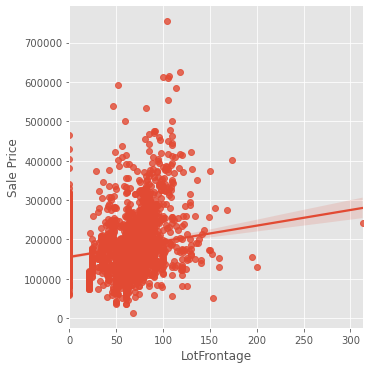

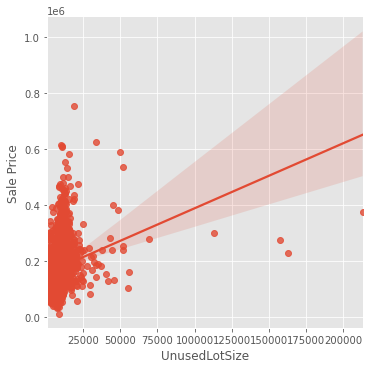

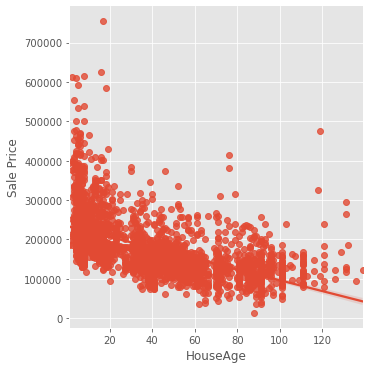

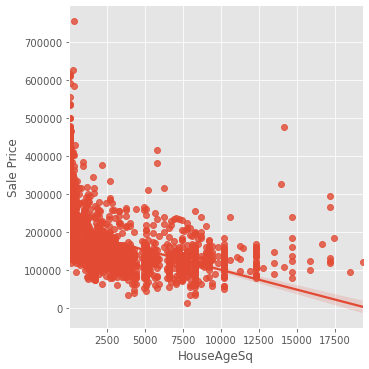

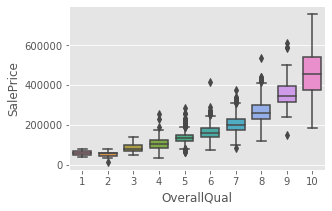

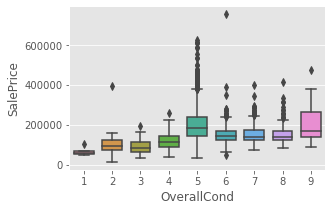

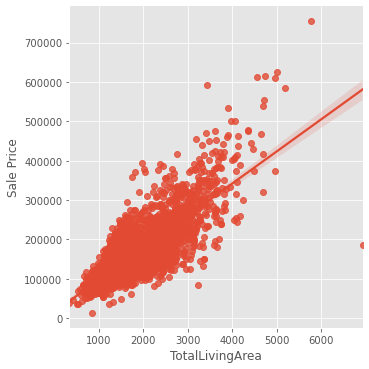

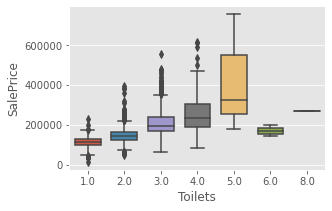

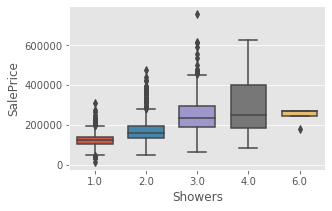

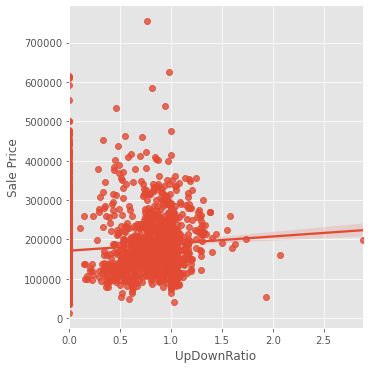

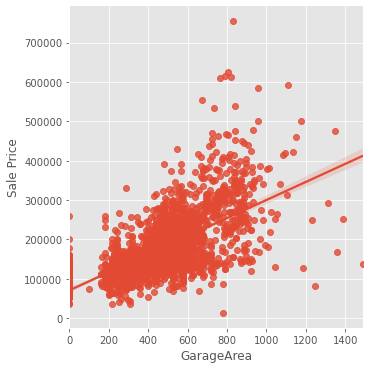

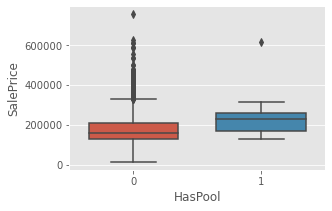

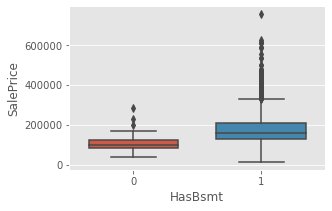

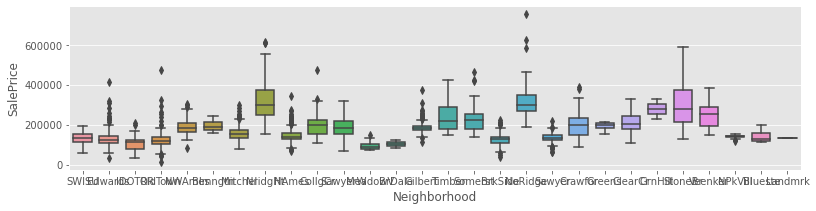

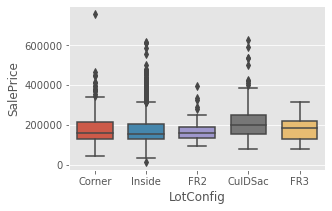

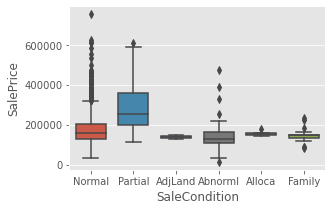

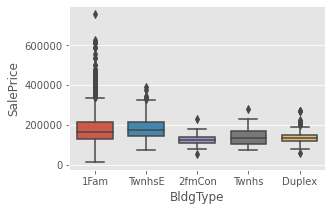

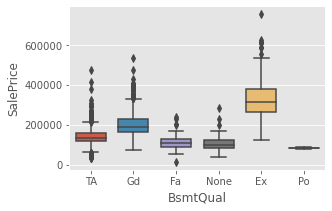

In [84]:
for col in df.columns:
    print(col)
    if col in box_vars:
        if col in ['Neighborhood']:
            aspect_val = 4
        else:
            aspect_val = 1.6
        sns.catplot(x=col, y="SalePrice",
                        data=df, kind="box",
                        height=2.8,aspect=aspect_val, width=0.7).set_axis_labels(x_var=col,y_var='SalePrice')
    elif col != 'SalePrice':
        sns.lmplot(x=col, y="SalePrice",
                   data=df,sharex=False).set_axis_labels(y_var='Sale Price')

MLL Viz Things

In [44]:
import statsmodels.api as sm
def ols(housing, regress_vars,dummy_dict):
    X = housing[regress_vars].copy()
    dummy_df = dummify(housing, dummy_dict)
    X = pd.concat([X,dummy_df], axis=1)
    X = sm.add_constant(X)
    y = np.log(housing['SalePrice'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
    #reg = sm.OLS(y_train, X_train)
    reg = sm.OLS(y_train, X_train.astype(float)).fit()
    #ans = reg.fit()
    print(reg.summary())
    return reg

In [45]:
results = ols(df,chosen_vars, dummy_vars)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     309.7
Date:                Fri, 05 Mar 2021   Prob (F-statistic):               0.00
Time:                        08:38:34   Log-Likelihood:                 1372.6
No. Observations:                2063   AIC:                            -2631.
Df Residuals:                    2006   BIC:                            -2310.
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               4.9981      0.019    2

In [46]:
table = pd.DataFrame(results.summary().tables[1].data[1:])

table.columns = ['name','coef','std err','t value','p value','2.5% confidence','97.5% confidence']
table = table.astype({'name':str,'coef':float,'std err':float, 't value':float, 'p value':float, '2.5% confidence':float, '97.5% confidence':float})
slope_table = table[['name', 'coef', '2.5% confidence', '97.5% confidence']].iloc[1:]
#slope_table.name = df.columns

<AxesSubplot:xlabel='name', ylabel='std err'>

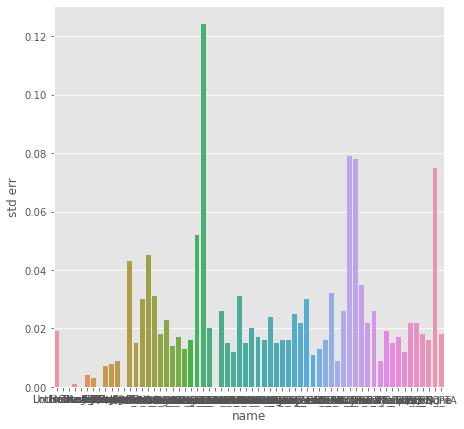

In [47]:
sns.barplot(x='name', y='std err', data=table)

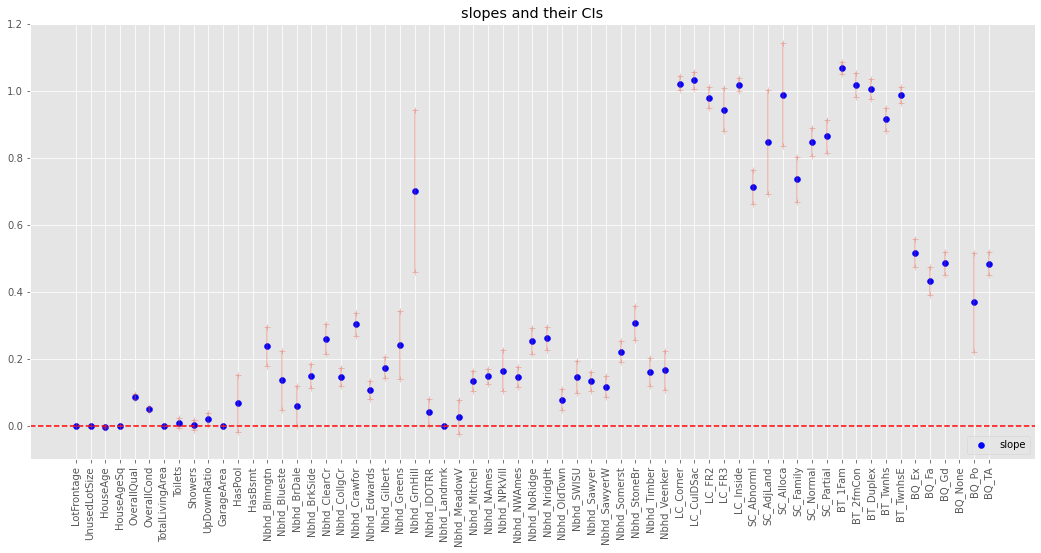

In [62]:
plt.rcParams['figure.figsize'] = (18,8)
y_min, y_max = -.1,1.2

slope_table['y_min'] = slope_table['2.5% confidence'].map(lambda t:(t-y_min)/(y_max-y_min))
slope_table['y_max'] = slope_table['97.5% confidence'].map(lambda t:(t-y_min)/(y_max-y_min))
x = range(1,len(slope_table)+1)
plt.scatter(x, slope_table['coef'], label='slope', c='b')
plt.axhline(0,linestyle='--', c='r')

for i in x:
    plt.axvline(i, ymin=slope_table['y_min'][i], ymax=slope_table['y_max'][i], marker='+', alpha=0.3)
plt.xticks(x,slope_table.name,rotation='vertical')
plt.ylim((y_min, y_max))
plt.title('slopes and their CIs')
plt.legend(loc=4)

Alpha Performance Lasso

In [63]:
X = housing[config.CHOSEN_VARIABLES]
dummy_df = dummify(housing, dummy_vars, drop_first=True)
X = pd.concat([X,dummy_df], axis=1)
y = np.log(housing['SalePrice'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [64]:
lasso = Lasso()

In [88]:
train_R2 = []
test_R2  = []
train_predictions = []
test_predictions = []

alphaRange = np.linspace(1e-10,0.003,200)
#alphaRange = [.0001]
for alpha in alphaRange:
    lasso.set_params(alpha=alpha, normalize=True, max_iter=10000)  
    lasso.fit(X, y)
    train_R2.append(lasso.score(X_train, y_train))
    test_R2.append(lasso.score(X_test, y_test))
    
    test_prediction = lasso.predict(X_test)
    train_prediction = lasso.predict(X_train)
    
    train_predictions.append(abs(train_prediction-y_train).mean())
    test_predictions.append(abs(test_prediction-y_test).mean())

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9318968213824732, tolerance: 0.03868879896650691
  model = cd_fast.enet_coordinate_descent(


In [89]:
# predictions = lasso.predict(X)
# abs(predictions - y).mean()

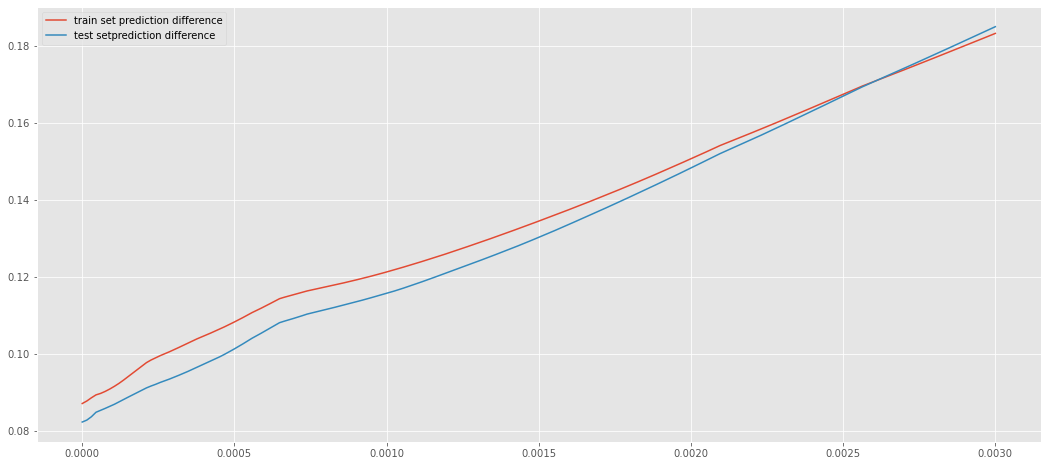

In [90]:
from matplotlib import pyplot as plt
plt.plot(alphaRange, train_predictions, label=r'train set prediction difference')
plt.plot(alphaRange, test_predictions, label=r'test setprediction difference')
plt.legend()

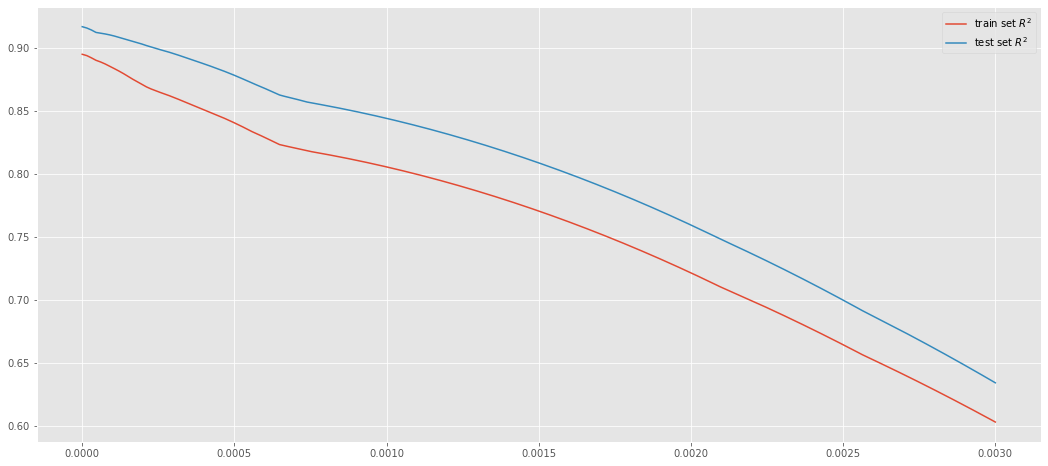

In [66]:
from matplotlib import pyplot as plt
plt.plot(alphaRange, train_R2, label=r'train set $R^2$')
plt.plot(alphaRange, test_R2, label=r'test set $R^2$')
plt.legend()

In [69]:
# def Penalization_term(beta, alpha, rho = 0, penalize='Lasso'):
#     if penalize not in ['Ridge', 'Lasso', 'ElasticNet']: raise ValueError('The token ${\bf penalize}$ is invalid!')
#     if penalize == 'Ridge':
#             return alpha * np.sum(beta[1:]**2)
#     elif penalize == 'Lasso':
#             return alpha * np.sum(np.abs(beta[1:]))
#     elif penalize == 'ElasticNet':
#             return alpha * (rho * np.sum(np.abs(beta[1:])) + (1 - rho) * np.sum(beta[1:]**2))

In [68]:
# N = 100
# rho = 0
# penalize = 'Lasso'
# plt.rcParams['figure.figsize'] = (7,7)
# x = df['GarageArea']
# y = df['SalePrice']
# beta1, beta2 = np.meshgrid(x, y) # first and second slope coefficients

# beta   = np.concatenate((np.zeros((N**2,1)), beta1.reshape((-1,1)), beta2.reshape((-1,1))), axis=1)

# Z = np.array(list(map(lambda t: Penalization_term(t, 1.0, rho=rho, penalize=penalize), beta)))

# Z = Z.reshape((N, N))  # reshape the penalization values into a square matrix

# fig, ax = plt.subplots()
# CS = ax.contour(beta1, beta2, Z)
# ax.clabel(CS, inline=1, fontsize=10)
# ax.set_title('%s Penalization' %(penalize))